In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# plt.style.use('tufte')

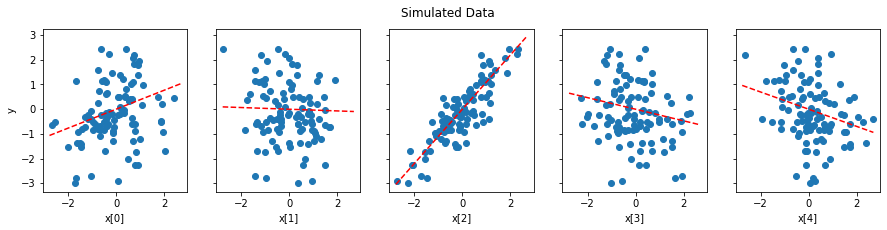

In [3]:
# Trailing underscore means the model has no access to the variable
np.random.seed(0)

ndims = 5
ndata = 100
X = np.random.randn(ndata, ndims)
w_ = np.random.randn(ndims)

noise_ = 0.1 * np.random.randn(ndata)
y_obs = X.dot(w_) + noise_


fig, axes = plt.subplots(sharey=True, ncols=ndims, figsize=(15, 3))

t = np.linspace(X.min(), X.max())
for idx, (ax, x) in enumerate(zip(axes.ravel(), X.T)):
    ax.plot(x, y_obs, 'o');
    ax.plot(t, w_[idx] * t, 'r--')
    ax.set_xlabel(f'x[{idx}]')
axes[0].set_ylabel('y')
fig.suptitle('Simulated Data');

## The Model

We have generated a linear regression dataset with 5 dimensions and 100 datapoints. 

In each library, we will define the joint probability distribution

$$
p(\mathbf{w}) \sim \mathcal{N}(\mathbf{0}, I_5)\\
p(\mathbf{y} | X, \mathbf{w}) \sim \mathcal{N}(X\mathbf{w}, 0.1I_{100}),
$$
where $I_5$ is a $5 \times 5$ identity matrix, and $I_{100}$ a $100 \times 100$ identity.

We then provide code to sample 1,000 draws from the posterior distribution: 

$$
p(\mathbf{w} | X, \mathbf{y}) \propto p(\mathbf{y} | X, \mathbf{w}) p(\mathbf{w})
$$

Note that in this case we can just do the math, and the actual posterior is

$$
p(\mathbf{w} | X, \mathbf{y}) = \mathcal{N}((X^TX + I_5)^{-1}X^Ty, (X^TX + I_5)^{-1})
$$



In [4]:
num_warmup = 1000
num_samples = 1000
num_chains = 4

## PyStan 3

In [5]:
import nest_asyncio
nest_asyncio.apply()

In [6]:
import stan

In [7]:
import pkg_resources
pkg_resources.get_distribution('pystan').version

'3.3.0'

In [8]:
linear_regression = """
data {
  int<lower=0> N;   // number of data items
  int<lower=0> K;   // number of predictors
  matrix[N, K] X;   // predictor matrix
  vector[N] y;      // outcome vector
}
parameters {
  vector[K] w;       // coefficients for predictors
}
model {
  y ~ normal(X * w, 0.1);  // likelihood
}
"""

linear_data = {'N': ndata,
               'K': ndims,
               'y': y_obs,
               'X': X
              }

In [9]:
posterior = stan.build(linear_regression, data=linear_data, random_seed=1)

Building: found in cache, done.
Messages from stanc:


In [10]:
fit = posterior.sample(num_chains=num_chains, num_warmup=num_warmup, num_samples=num_samples)

Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


## Tensorflow Probability

In [11]:
import tensorflow as tf
import tensorflow_probability as tfp

In [12]:
print(tf.__version__)
print(tfp.__version__)

2.7.0
0.15.0


In [13]:
tfd = tfp.distributions

X_tensor = tf.convert_to_tensor(X, dtype='float32')

@tf.function
def target_log_prob_fn(w):
    w_dist = tfd.Normal(loc=tf.zeros((ndims, 1)), scale=1.0, name="w")
    w_prob = tf.reduce_sum(w_dist.log_prob(w))
    y_dist = tfd.Normal(loc=tf.matmul(X_tensor, w), scale=0.1, name="y")
    y_prob = tf.reduce_sum(y_dist.log_prob(y_obs.reshape(-1, 1)))
    return w_prob + y_prob

In [14]:
# Initialize the HMC transition kernel.

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=4,
        step_size=0.01),
    num_adaptation_steps=int(num_warmup * 0.8))

tfp_samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_samples,
    num_burnin_steps=num_warmup,
    current_state=tf.zeros((ndims, 1)),
    kernel=adaptive_hmc,
    trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

In [15]:
# implement chains for tfp: https://juanitorduz.github.io/tfp_hcm/

## Pyro

In [16]:
import pyro
import torch
from pyro.infer.mcmc import NUTS, MCMC
import pyro.distributions as dist

In [17]:
print(pyro.__version__)

1.7.0


In [18]:
def model(X):
    w = pyro.sample('w', dist.Normal(torch.zeros(ndims), torch.ones(ndims)))
    y = pyro.sample('y', dist.Normal(torch.matmul(X, w), 0.1 * torch.ones(ndata)), obs=torch.as_tensor(y_obs, dtype=torch.float32))
    return y

In [19]:
nuts_kernel = NUTS(model, adapt_step_size=True)
pyro_mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_warmup, num_chains=num_chains)
pyro_mcmc.run(torch.as_tensor(X, dtype=torch.float32))

Warmup [1]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/2000 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/2000 [00:00, ?it/s]

## numpyro



In [20]:
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config; config.update("jax_platform_name", "cpu")

import numpyro
import numpyro.distributions as dist
from numpyro import sample
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [21]:
print(jax.__version__)
print(numpyro.__version__)

0.2.25
0.8.0


In [22]:
def model(X):
    w = sample('w', dist.Normal(jnp.zeros(ndims), jnp.ones(ndims)))
    y = sample('y', dist.Normal(jnp.matmul(X, w), 0.1 * jnp.ones(ndata)), obs=y_obs)

In [23]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(
    rng_key_, X=X
)
mcmc.print_summary()
npyro_samples = mcmc.get_samples()

/Users/zhishiw/.pyenv/versions/3.7.8/envs/ppl-env-378/lib/python3.7/site-packages/numpyro/infer/mcmc.py:280: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.num_chains, local_device_count(), self.num_chains
sample: 100%|██████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 8596.79it/s, 7 steps of size 6.23e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      w[0]      0.37      0.01      0.37      0.36      0.39   5075.55      1.00
      w[1]     -0.04      0.01     -0.04     -0.05     -0.02   4453.21      1.00
      w[2]      1.09      0.01      1.09      1.08      1.11   4906.69      1.00
      w[3]     -0.23      0.01     -0.23     -0.25     -0.22   4947.59      1.00
      w[4]     -0.34      0.01     -0.34     -0.36     -0.32   3957.17      1.00

Number of divergences: 0


## Check Accuracy

In [24]:
true = np.linalg.inv(X.T.dot(X) + np.eye(5)).dot(X.T.dot(y_obs))

In [25]:
outputs = {
    'pystan': fit['w'].mean(axis=1),
    'pyro': pyro_mcmc.get_samples()['w'].numpy().mean(axis=0),
    'numpyro': npyro_samples['w'].mean(axis=0),
    'tfp': tf.reduce_mean(tfp_samples, axis=0).numpy().flatten(),
}

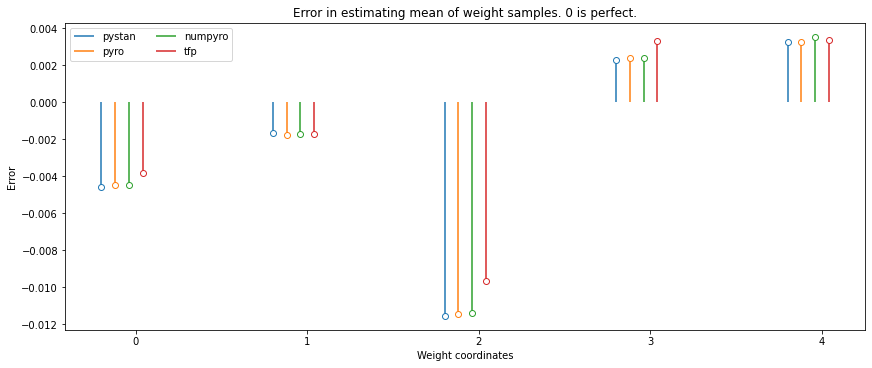

In [26]:
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)
bg = ax.get_facecolor()

offset = 0.4

for idx, (name, value) in enumerate(outputs.items()):
    x = np.arange(5) + (idx * offset / 5 - offset / 2)
    y = true - value.flatten()
    ax.vlines(x, 0, y, label=name, color=f'C{idx}')
    ax.plot(x, y, 'o', color=f'C{idx}', mfc=bg)

ax.set_title('Error in estimating mean of weight samples. 0 is perfect.')
ax.set_ylabel('Error')
ax.set_xlabel('Weight coordinates')
ax.legend(ncol=2);